This script creates daily data by aggregating hourly data.  It then saves the created data structure as a pickle (a compressed binary file) for faster loading in the future.

# Daily Data #

In [5]:
# imports
import pandas as pd
import numpy as np
import time
from timeit import default_timer as timer

In [6]:
# define data location
# location = '/Users/mithras/Documents/_SCHOOL/_Drexel/BUSN 710 - Capstone/Data/Forecasting Project/'
location = '/Users/loki/Documents/_SCHOOL/_Drexel/BUSN 710 - Capstone/Data/Forecasting Project/'

## Data Cleaning & Checking 

In [7]:
# # hourly data

# use_oct_in = pd.read_excel(location+'PECO Zip HourlyUsage_2017.10.xlsx')
# use_nov_in = pd.read_excel(location+'PECO Zip HourlyUsage_2017.11.xlsx') 
# use_dec_in = pd.read_excel(location+'PECO Zip HourlyUsage_2017.12.xlsx') 
# use_jan_in = pd.read_excel(location+'Zip_HourlylUsage_2018.01.xlsx')
# use_feb_in = pd.read_excel(location+'PECO Zip HourlyUsage_2018.02.xlsx')
# use_mar_in = pd.read_excel(location+'PECO Zip HourlyUsage_2018.03.xlsx')
# use_apr_in = pd.read_excel(location+'PECO Zip HourlyUsage_2018.04.xlsx')
# use_may_in = pd.read_excel(location+'PECO Zip HourlyUsage_2018.05.xlsx')
# use_jun_in = pd.read_excel(location+'PECO Zip HourlyUsage_2018.06.xlsx')
# use_jul_in = pd.read_excel(location+'Zip_HourlylUsage_2018.07.xlsx')
# use_aug_in = pd.read_excel(location+'PECO Zip HourlyUsage_2018.08.xlsx')
# use_sep_in = pd.read_excel(location+'PECO Zip HourlyUsage_2018.09.xlsx')

# end = timer()
# print((end - start)/60) # Time in minutes (~15 min)

In [8]:
# # merge use data
# hourly_in = [use_oct_in, use_nov_in, use_dec_in, use_jan_in, use_feb_in, use_mar_in, 
#              use_apr_in, use_may_in, use_jun_in, use_jul_in, use_aug_in, use_sep_in]
             
# use = pd.concat(hourly_in)

In [9]:
# del (use_oct_in, use_nov_in, use_dec_in, use_jan_in, use_feb_in, use_mar_in, 
#      use_apr_in, use_may_in, use_jun_in, use_jul_in, use_aug_in, use_sep_in)
# del hourly_in

In [10]:
# # save as pickle so we don't have to do this again
# use.to_pickle(location+'fcast_use_raw.pkl.zip')
# del use

In [11]:
# load pickle
start = timer()

use = pd.read_pickle(location+'hourly_use_raw.pkl.zip')

end = timer()
print((end - start)/60) # Time in minutes (~.2 min - MUCH FASTER!!)

0.30873919785


In [13]:
# create ID tuple
ids = pd.Series(list(map(tuple, use[['DACCOUNTID', 'DMETERNO']].values)))
use['ID'] = ids.values

# find gas records
use = use.loc[use['UOM'] == 'CCF']
use = use.drop(columns=['UOM'])

# convert to datetime
use['Dt'] =  pd.to_datetime(use['METERREADDATE'])

In [14]:
# load customer data
customer_in = pd.read_excel(location+'PECO Zip Customer 2018.10.01 v2.xlsx', sheet_name="Account")
ids = pd.Series(list(map(tuple, customer_in[['DACCOUNTID', 'DMETERNO']].values)))
customer_in['ID'] = ids.values
customer = customer_in.drop(columns=['CITY', 'STATE', 'ZIPCODE', 'COUNTYCODE'])
del customer_in

In [15]:
customer.head()

,DACCOUNTID,DCUSTOMERID,DMETERNO,TARIFF,FUELTYPE,REVENUCODE,ID
0,156414999216,20325174427256,5472978430796,ER0,ELECTRIC,12.0,"(156414999216, 5472978430796)"
1,156414999216,20325174427256,4464803701784,GH0,GAS,12.0,"(156414999216, 4464803701784)"
2,432330788012,20325174427256,4464883887376,GH0,GAS,12.0,"(432330788012, 4464883887376)"
3,432330788012,20325174427256,5472996672436,ER0,ELECTRIC,12.0,"(432330788012, 5472996672436)"
4,469011116536,21879168677436,604933845496,GH0,GAS,1.0,"(469011116536, 604933845496)"


## Data Restructuring ##

In [24]:
# functions for naming consistency
def decrement(x, startswith, split):
    """
    decrements a passed string of form "demo#" by 1
    
    Parameters
    ----------
    x : string to be decremented
    split : string to split on

    Returns
    ----------
    y : decremented string
    """
    if x.startswith(startswith):
        a,b = x.split(split)
        b = int(b)-1
        y = a + split + str(b)

        return y

    else:
        return x

    
def interval_to_hour(df):
    """
    function for fast rename/relabel during tidying process
    
    Parameters
    ----------
    df : pandas data frame

    Returns
    ----------
    df : data frame with updated column names
    """
    
    df = df.rename(columns=lambda x: decrement(x, "INTERVAL_", "_"))
    df = df.rename(columns=lambda x: x.replace("INTERVAL_", "HR"))
    return df

In [25]:
# rename for consistency
use = interval_to_hour(use)
use = use.drop(columns=['METERREADDATE','HR24'])

In [26]:
# Tidy / Stack data (transform into tall data - one row per customer per hour):
# ref: http://www.jeannicholashould.com/tidy-data-in-python.html
tidy_use = pd.melt(use, 
                   id_vars=['ID','DACCOUNTID','DMETERNO','Dt'],
                   var_name='Hour', value_name='Use')


In [27]:
# drop use from memory
del use

In [28]:
# relabel/retype
tidy_use['Hour'] = tidy_use['Hour'].str.extract('(\d+)').astype(int)
tidy_use = tidy_use.sort_values(by=["Dt"])

### Make daily data ###

In [29]:
# for daily aggregation
daily_use = tidy_use[['ID','Use','Dt']]
daily_use['Dt'] = daily_use['Dt'].dt.date
daily_use['Dt'] =  pd.to_datetime(daily_use['Dt'])
daily_use = daily_use.groupby(['ID','Dt']).sum().reset_index()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [30]:
# append rate code data
daily_use = daily_use.merge(customer, how='inner', on=['ID'])
#daily_use.head()

In [31]:
# Add dummy variables for day-of-week
daily_use['Weekday'] = pd.get_dummies(daily_use['Dt'].dt.weekday < 5)[True]

# Add dummy variables for holidays
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
#dr = pd.date_range(start=min(tidy_use['Dt']), end=max(tidy_use['Dt']))
dr = pd.date_range(start="1-1-2010", end="12-31-2020")
holidays = cal.holidays(start=dr.min(), end=dr.max())

daily_use['Holiday'] = pd.get_dummies(daily_use['Dt'].isin(holidays))[True]
del (USFederalHolidayCalendar, cal, dr, holidays)
#daily_use.head()

In [32]:
# sort by date & time
daily_use = daily_use.sort_values(by=['Dt'])
print(daily_use.shape)
daily_use.head()

(2279446, 11)


,ID,Dt,Use,DACCOUNTID,DCUSTOMERID,DMETERNO,TARIFF,FUELTYPE,REVENUCODE,Weekday,Holiday
495153,"(68881639149832, 606395738288)",2017-10-01,1.00,68881639149832,3188526427696,606395738288,GH0,GAS,1.0,0,0
482563,"(68690879683500, 608923719096)",2017-10-01,0.00,68690879683500,19731696176432,608923719096,GH0,GAS,1.0,0,0
1063222,"(164788222898932, 640944705832)",2017-10-01,1.14,164788222898932,33149958808264,640944705832,GH0,GAS,1.0,0,0
482201,"(68689501197696, 726789359116)",2017-10-01,2.00,68689501197696,756418245856,726789359116,GH0,GAS,1.0,0,0
160918,"(20628346369984, 640143121596)",2017-10-01,4.12,20628346369984,24713480259220,640143121596,UHC,GAS,3.0,0,0


#### Quick look at amount of data we have per ID ####

In [34]:
# drop records with missing data
if len(daily_use) == len(daily_use.dropna(subset=['Use'])):
    print(f'There is no missing data in the {len(daily_use)} rows of useage data')
else:
    daily_use = daily_use.dropna(subset=['Use'])

There is no missing data in the 2279446 rows of useage data


In [35]:
print(f"There are {len(daily_use['DACCOUNTID'].drop_duplicates())} unique AccountIDs in the data")
print(f"There are {len(daily_use['DMETERNO'].drop_duplicates())} unique MeterNos in the data")
ids = daily_use['ID'].drop_duplicates()
print(f"There are {len(ids)} unique AccountID / MeterNo pairs in the data")

There are 6976 unique AccountIDs in the data
There are 6953 unique MeterNos in the data
There are 7097 unique AccountID / MeterNo pairs in the data


Text(0.5, 1.0, 'Frequency of IDs with X dates')

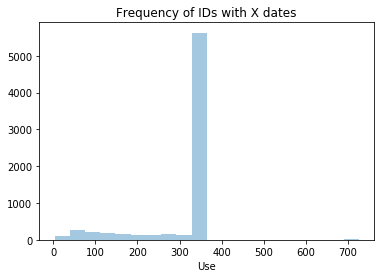

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
ids_to_plot = daily_use.groupby('ID').count()
sns.distplot(ids_to_plot['Use'], bins=20, kde=False, rug=False)
plt.title('Frequency of IDs with X dates')

Text(0.5, 1.0, 'Frequency of IDs with at least 330 dates')

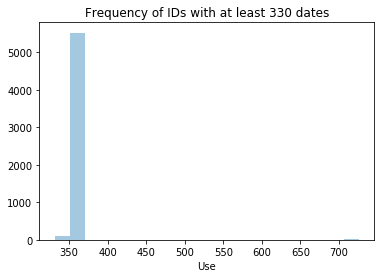

In [38]:
sns.distplot(ids_to_plot[ids_to_plot['Use'] > 330]['Use'], bins=20, kde=False, rug=False)
plt.title('Frequency of IDs with at least 330 dates')

In [ ]:
#for i in range(1,365):
#    print(f"{ids_to_plot[ids_to_plot['Use'] >= i]['Use'].count()} records have >={i} dates")

#### Find IDs with sufficient data to build initial segments on --> reliable training set ####

In [39]:
# find IDs with at least 360 days of data
sufficient_ids = ids_to_plot[ids_to_plot['Use'] >= 360].reset_index()['ID']
print(f"{100*len(sufficient_ids)/len(daily_use['ID'].unique())} percent of IDs have at least 360 days of data")

76.90573481752854 percent of IDs have at least 360 days of data


In [40]:
# find the dates for which sufficient_ids all have data
pivoted = (daily_use[daily_use['ID'].isin(sufficient_ids)]
           .pivot_table(index='Dt', columns=['ID'], values='Use', fill_value=None))
sufficient_dates = pivoted.dropna().reset_index()['Dt']
del pivoted
print(f"The IDs with sufficient data overlap on {len(sufficient_dates)} days of the most recent year of data")

The IDs with sufficient data overlap on 322 days of the most recent year of data


In [41]:
# filter total use dataset to contain only IDs who have sufficient data and only dates where sufficient_ids have data
sufficient_use = daily_use[(daily_use['ID'].isin(sufficient_ids)) & (daily_use['Dt'].isin(sufficient_dates))]
#sufficient_use.head()

In [42]:
#sanity check
print(len(daily_use))
print(len(sufficient_use))
print(len(ids))
print(len(sufficient_ids))

2279446
1767458
7097
5458


#### Subgroup detection ####

In [43]:
# print(daily_use[['ID','REVENUCODE']].drop_duplicates().groupby('REVENUCODE').count())
# print("nan           "+str(len(use[np.isnan(use['REVENUCODE'])][['ID']].drop_duplicates())))

In [44]:
# print(daily_use[['ID','REVENUCODE']].drop_duplicates().groupby('REVENUCODE').count())
# print("nan           "+str(len(use[np.isnan(use['REVENUCODE'])][['ID']].drop_duplicates())))

In [45]:
# # recode 'REVENUCODE' as 'TYPE'
# def recode(df):
#     """combines REVENUCODE groups 1,12,nan to HOME and 3,5 to COMMERICAL"""
#     df['TYPE'] = None
#     df.loc[ df.REVENUCODE == 1, 'TYPE' ] = 'HOME'
#     df.loc[ df.REVENUCODE == 12, 'TYPE' ] = 'HOME'
#     df.loc[ np.isnan(df['REVENUCODE']), 'TYPE' ] = 'HOME'
#     df.loc[ df.REVENUCODE == 3, 'TYPE' ] = 'COMM'
#     df.loc[ df.REVENUCODE == 5, 'TYPE' ] = 'COMM'
    
#     #df['TYPE'][df['REVENUCODE']==1] = 'HOME'
#     #df['TYPE'][df['REVENUCODE']==12] = 'HOME'
#     #df['TYPE'][np.isnan(df['REVENUCODE'])] = 'HOME'
#     #df['TYPE'][df['REVENUCODE']==3] = 'COMM'
#     #df['TYPE'][df['REVENUCODE']==5] = 'COMM'
    
#     return df

In [46]:
# # ignore errors
# daily_use = recode(daily_use)
# sufficient_use = recode(sufficient_use)

### Save ###

In [47]:
# save file(s) as pickles
# using save location to save with other data files outside of git repo
# data.to_csv(location+'peco.csv', sep='\t')
daily_use.to_pickle(location+'peco_daily.pkl.zip')
sufficient_use.to_pickle(location+'peco_sufficient_daily.pkl.zip')
ids.to_pickle(location+'peco_daily_ids.pkl.zip')
sufficient_ids.to_pickle(location+'peco_sufficient_daily_ids.pkl.zip')

 ### Merge use & weather? ###

In [ ]:
# # load data
# daily = pd.read_pickle(location+'peco_daily.pkl.zip')
# sufficient_daily = pd.read_pickle(location+'peco_sufficient_daily.pkl.zip')
# weather = pd.read_pickle(location+'daily_weather.pkl.zip')

In [ ]:
# # merge
# daily = pd.merge(daily, weather, how='inner', on=['Dt'])
# sufficient_daily = pd.merge(sufficient_daily, weather, how='inner', on=['Dt'])
# # CustIDs || Date | Consumption |||| Weather_variables